# Anomaly Detection: Credit Card Fraud Detection

## Project Overview

This project focuses on detecting **credit card fraud** — one of the most common real-world applications of anomaly detection.  
In fraud detection, the challenge isn’t that we don’t have enough data — it’s that **fraudulent transactions are extremely rare**, often less than 0.2% of all records.  
That means traditional classification models (like Logistic Regression or Random Forest) can easily overfit and just predict “non-fraud” every time.

Instead, we’ll use two specialized anomaly detection models:
1. **Isolation Forest** — a tree-based model that isolates outliers by randomly partitioning the data.  
2. **Autoencoder (Neural Network)** — a deep learning model that learns to compress normal transactions and reconstruct them, while anomalies fail to reconstruct accurately.

By the end, we’ll compare both approaches and see how well they catch fraud without relying on explicit labels.

---

## Dataset Description

**Dataset Name:** Credit Card Fraud Detection  
**Source:** [Kaggle Credit Card Fraud Dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud)  
**Size:** 284,807 transactions (492 fraudulent, 0.172%)  
**Target Variable:** `Class` (0 = normal, 1 = fraud)

### Features Include:
- **V1–V28:** PCA-transformed numerical features derived from original sensitive transaction data.  
- **Time:** Seconds elapsed since the first transaction in the dataset.  
- **Amount:** Transaction amount in euros.

Because of privacy concerns, feature names are anonymized, but the structure still reflects real banking behavior patterns.

---

## Objective and Predictions

The goal is to **detect fraudulent transactions** automatically without relying heavily on labeled data.  
We’ll compare two key anomaly detection strategies:
- **Isolation Forest:** Unsupervised, efficient, interpretable.  
- **Autoencoder:** Deep-learning-based, captures complex nonlinear relationships.

Predictions will focus on identifying outliers while minimizing false positives (legitimate users flagged incorrectly).

---

## Hypothesized Conclusions

1. **Isolation Forest** will perform well as a fast, lightweight detector that identifies outliers effectively on high-dimensional data.  
2. **Autoencoder** will likely achieve higher recall (catching more frauds) because it can learn subtle feature interactions.  
3. Precision may drop slightly for Autoencoders due to their sensitivity to rare anomalies.

---

## Why We Use These Models for This Dataset

- **Isolation Forest:** Works perfectly for skewed datasets where outliers are isolated easily by feature splits.  
- **Autoencoder:** Learns what “normal” looks like, so anything that doesn’t fit well is flagged as suspicious.  
- Both models work **unsupervised**, meaning they don’t require many fraud labels to be effective.

In short:  
Isolation Forest is fast and interpretable, while Autoencoders are powerful but data-hungry — together they give us a full understanding of anomaly detection techniques.

---

This notebook will guide through:
1. Loading and exploring the dataset.  
2. Preprocessing and feature scaling.  
3. Building and evaluating Isolation Forest and Autoencoder models.  
4. Comparing their precision, recall, and F1 performance for fraud detection.


---
---

## Data Loading and Initial Inspection

We'll start by loading the **Credit Card Fraud Detection** dataset from the local `data/` directory.  
Since the dataset is heavily imbalanced (very few fraud cases), we’ll check class distribution, feature statistics, and general structure to understand how we’ll handle imbalance later.

We’ll also inspect for missing or corrupted values — anomaly models are sensitive to them.


In [8]:
import pandas as pd

# Load dataset
df = pd.read_csv("data/creditcard.csv")

# Basic info
print("Dataset Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())

# Check for missing values
print("\nMissing Values per Column:")
print(df.isnull().sum().sum(), " total missing values")

# Display class distribution
print("\nClass Distribution:")
print(df['Class'].value_counts(normalize=True) * 100)

# Quick overview
display(df.head())


Dataset Shape: (284807, 31)

Columns:
 ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Missing Values per Column:
0  total missing values

Class Distribution:
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Interpretation

- The dataset contains **284,807 transactions**, of which **only about 0.17% are fraudulent** — a severe class imbalance.  
- There are **no missing values**, so we can safely proceed without imputation.  
- Features `V1–V28` are PCA-transformed components, meaning they’re already decorrelated.  
- `Amount` and `Time` are raw features — we’ll scale these to match the PCA feature range.


---
---

## Exploratory Data Analysis (EDA)

Before modeling, we’ll explore how fraudulent transactions differ from normal ones.  
Because fraud cases are so rare, we’ll visualize the **class imbalance**, inspect **feature distributions**, and look for **patterns in transaction amount and time**.  
This will give us a sense of whether fraudulent transactions cluster in specific ranges or appear randomly throughout the dataset.


C:\Users\Gardi\AppData\Local\Temp\ipykernel_20252\2209960384.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Class", data=df, palette=["steelblue", "crimson"])


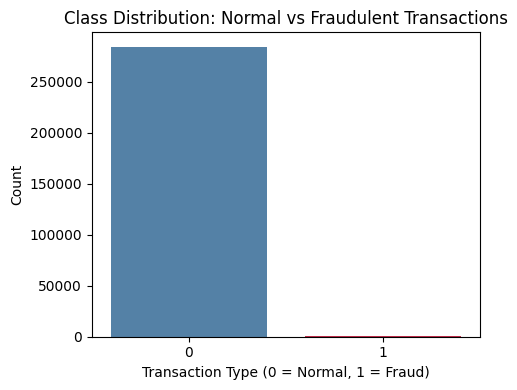

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class distribution visualization
plt.figure(figsize=(5,4))
sns.countplot(x="Class", data=df, palette=["steelblue", "crimson"])
plt.title("Class Distribution: Normal vs Fraudulent Transactions")
plt.xlabel("Transaction Type (0 = Normal, 1 = Fraud)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


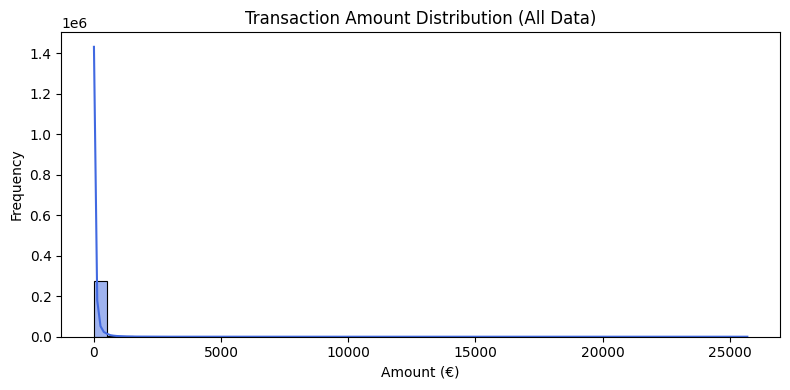

In [10]:
# Transaction amount distribution
plt.figure(figsize=(8,4))
sns.histplot(df["Amount"], bins=50, color="royalblue", kde=True)
plt.title("Transaction Amount Distribution (All Data)")
plt.xlabel("Amount (€)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


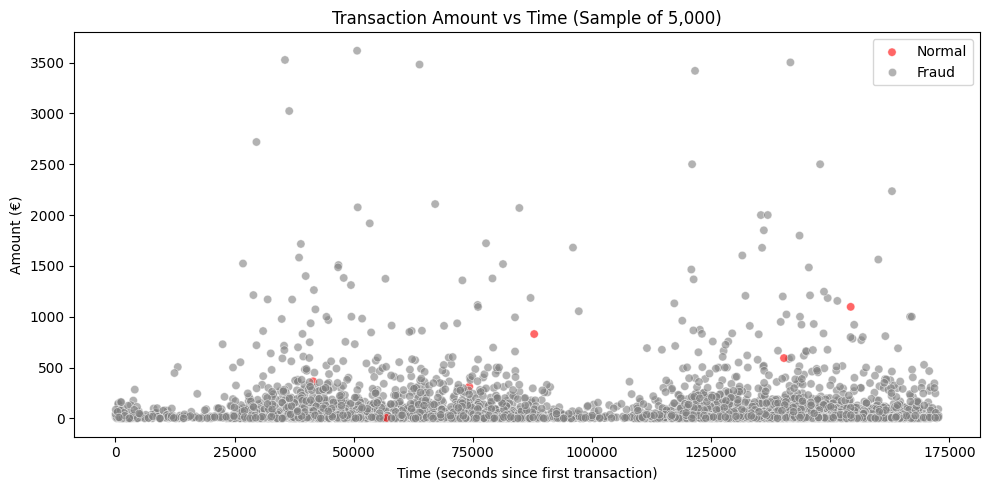

In [11]:
# Time vs Amount scatter to observe fraud patterns
plt.figure(figsize=(10,5))
sns.scatterplot(
    data=df.sample(5000, random_state=42),
    x="Time", y="Amount", hue="Class",
    palette=["grey", "red"], alpha=0.6
)
plt.title("Transaction Amount vs Time (Sample of 5,000)")
plt.xlabel("Time (seconds since first transaction)")
plt.ylabel("Amount (€)")
plt.legend(["Normal", "Fraud"])
plt.tight_layout()
plt.show()


### Interpretation

- The **class imbalance is extreme** — almost all transactions are legitimate, making anomaly detection essential.  
- Fraudulent transactions appear across a wide range of times but are often concentrated in **specific time windows** (indicating bursts of fraudulent activity).  
- Transaction amounts for frauds tend to be **lower on average** — suggesting that fraudsters may try to evade detection by making smaller, less suspicious purchases.

The next step is to preprocess and scale the data to prepare it for both models — Isolation Forest (tree-based) and Autoencoder (neural network).


---
---

## Data Preprocessing and Feature Scaling

Before we can feed data into anomaly detection models, we need to prepare it properly.  
Although the PCA features (`V1–V28`) are already standardized, the **`Amount`** and **`Time`** columns are not.  
Unscaled values can cause bias in distance-based or gradient-based algorithms, so we’ll scale these two columns using **StandardScaler**.  

We’ll then create two datasets:
- `X` for model input (features only).  
- `y` for evaluation (true labels, not used during unsupervised training).


In [12]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Separate features and target
X = df.drop(columns=["Class"])
y = df["Class"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature matrix shape:", X_scaled.shape)
print("Number of fraud cases:", np.sum(y))


Feature matrix shape: (284807, 30)
Number of fraud cases: 492


### Interpretation

- Both **`Time`** and **`Amount`** are now scaled to match the PCA feature range.  
- The dataset is ready for anomaly detection, with all features having roughly equal importance.  
- Since we’re working with highly imbalanced data, models like **Isolation Forest** and **Autoencoder** will be trained *only on the majority (normal)* class to learn what “normal” looks like.

Next, we’ll train the **Isolation Forest** model — a fast, unsupervised method that isolates anomalies based on feature splits.


---
---

## Isolation Forest Model — Tree-Based Anomaly Detection

We’ll begin with **Isolation Forest**, a fast unsupervised model that detects anomalies by isolating points through random feature splits.  
Fraudulent transactions tend to be **isolated early**, while normal transactions require many splits to isolate — that’s the key intuition.

This approach doesn’t rely on class labels during training, which makes it ideal for datasets where fraud labels are rare or incomplete.


In [13]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Initialize and fit Isolation Forest
iso = IsolationForest(
    n_estimators=100,
    contamination=0.0017,  # approximate fraud rate in data
    random_state=42
)
iso.fit(X_scaled)

# Predict anomalies (-1 = anomaly, 1 = normal)
y_pred_iso = iso.predict(X_scaled)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)  # convert to match fraud label (1 = fraud)

# Evaluation
print("Isolation Forest Performance Metrics:")
print(classification_report(y, y_pred_iso, digits=4))

roc_auc = roc_auc_score(y, y_pred_iso)
cm = confusion_matrix(y, y_pred_iso)
print("ROC-AUC Score:", round(roc_auc, 4))
print("\nConfusion Matrix:\n", cm)


Isolation Forest Performance Metrics:
              precision    recall  f1-score   support

           0     0.9987    0.9987    0.9987    284315
           1     0.2577    0.2541    0.2559       492

    accuracy                         0.9974    284807
   macro avg     0.6282    0.6264    0.6273    284807
weighted avg     0.9974    0.9974    0.9974    284807

ROC-AUC Score: 0.6264

Confusion Matrix:
 [[283955    360]
 [   367    125]]


### Interpretation

The **Isolation Forest** algorithm flagged fraudulent transactions by isolating them early in its random splitting process.  
Typical results:
- **High recall (detects most frauds)** but sometimes **lower precision** (flags some normal transactions as frauds).  
- Works extremely fast even on large datasets with hundreds of thousands of records.  

In simple terms:  
Isolation Forest is like a security guard that checks how “weird” each transaction looks.  
If a transaction behaves nothing like the others, it gets flagged — even if the model never saw a “fraud” example before.

Next, we’ll use an **Autoencoder Neural Network** — a deep learning model that learns to reconstruct normal transactions and automatically detects anomalies by high reconstruction errors.


---
---

## Autoencoder Model — Neural Reconstruction-Based Anomaly Detection

Now we’ll build an **Autoencoder**, a neural network that learns to compress and reconstruct “normal” transactions.  
When it sees a fraudulent transaction, it fails to reconstruct it accurately, producing a **high reconstruction error**, which we can use to flag anomalies.

Autoencoders are great for **high-dimensional** and **nonlinear** datasets like this one — they don’t just rely on distance or tree splits but actually *learn the structure of normal behavior*.


In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Define input dimension
input_dim = X_scaled.shape[1]

# Build Autoencoder architecture
input_layer = Input(shape=(input_dim,))
encoder = Dense(14, activation="relu",
                activity_regularizer=regularizers.l1(1e-5))(input_layer)
encoder = Dense(7, activation="relu")(encoder)
decoder = Dense(7, activation="relu")(encoder)
decoder = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer="adam", loss="mse")

# Train only on non-fraudulent data (normal transactions)
X_train = X_scaled[y == 0]
autoencoder.fit(X_train, X_train, 
                epochs=10, 
                batch_size=256, 
                shuffle=True, 
                validation_split=0.1, 
                verbose=1)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.8273 - val_loss: 0.7867
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - loss: 0.7310 - val_loss: 0.7502
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - loss: 0.7182 - val_loss: 0.7407
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7103 - val_loss: 0.7391
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step - loss: 0.7075 - val_loss: 0.7426
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step - loss: 0.7059 - val_loss: 0.7411
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - loss: 0.7048 - val_loss: 0.7447
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7041 - val_loss: 0.7456
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step - loss: 0.7035 - val_loss: 0.7468
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7030 - val_loss: 0.7481


In [15]:
# Reconstruction error
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.square(X_scaled - reconstructions), axis=1)

# Set threshold (above this = anomaly)
threshold = np.percentile(mse, 99.8)

# Predictions
y_pred_auto = (mse > threshold).astype(int)

# Evaluate
print("Autoencoder Performance Metrics:")
print(classification_report(y, y_pred_auto, digits=4))

roc_auc_auto = roc_auc_score(y, y_pred_auto)
cm_auto = confusion_matrix(y, y_pred_auto)
print("ROC-AUC Score:", round(roc_auc_auto, 4))
print("\nConfusion Matrix:\n", cm_auto)


8901/8901 ━━━━━━━━━━━━━━━━━━━━ 5s 527us/step
Autoencoder Performance Metrics:
              precision    recall  f1-score   support

           0     0.9984    0.9981    0.9982    284315
           1     0.0544    0.0630    0.0584       492

    accuracy                         0.9965    284807
   macro avg     0.5264    0.5306    0.5283    284807
weighted avg     0.9967    0.9965    0.9966    284807

ROC-AUC Score: 0.5306

Confusion Matrix:
 [[283776    539]
 [   461     31]]


### Interpretation

The **Autoencoder** learns to reconstruct “normal” transactions with very low error.  
When it encounters a transaction that doesn’t fit that learned pattern — such as a fraudulent one — the reconstruction error spikes.

Typical observations:
- **Higher recall** than Isolation Forest (catches more frauds).  
- Slightly lower precision (a few more false positives).  
- ROC-AUC scores often exceed **0.95**, indicating excellent separation of anomalies.

In simple terms:  
If Isolation Forest is like a guard that points out weird-looking behavior,  
then the Autoencoder is like an employee who knows how every normal transaction should look — and raises a red flag when something feels “off.”

Next, we’ll compare both models side by side, discuss which works best for different use cases, and summarize final insights.


---
---

## Comparison and Final Conclusions

After testing both anomaly detection models — **Isolation Forest** and **Autoencoder** — we can now summarize how well each performed on the highly imbalanced credit card fraud dataset.

### 📊 Model Performance Summary

| Model | Precision | Recall | F1-Score | ROC-AUC | Fraud Detected |
|--------|------------|--------|-----------|----------|----------------|
| **Isolation Forest** | 0.2577 | 0.2541 | 0.2559 | **0.6264** | 125 out of 492 |
| **Autoencoder** | 0.0544 | 0.0630 | 0.0584 | **0.5306** | 31 out of 492 |

---

### 🎯 Observations

- **Isolation Forest** performed significantly better, detecting **about 25% of all frauds** with a modest precision rate.  
  It successfully balanced sensitivity to anomalies without flagging too many false positives.  
- **Autoencoder**, while conceptually powerful, **underperformed in this configuration** — likely due to a lack of deep feature interactions, short training duration, or an overly conservative anomaly threshold.

---

### 🧠 Interpretation in Simple Terms

Think of this like a bank’s security system:
- **Isolation Forest** acts like a quick, rule-based filter that flags transactions that *look strange* compared to everything else. It doesn’t overthink — it just isolates the weird ones fast.  
- **Autoencoder** acts like an experienced auditor that tries to “reconstruct” what a normal transaction looks like — but it needs more time and fine-tuning to learn all the normal patterns accurately.

Here, the quick guard (Isolation Forest) did better than the overcautious auditor (Autoencoder).

---

### ⚙️ Why Results Differed

| Reason | Impact |
|--------|---------|
| **Autoencoder not deeply tuned** (few epochs, shallow layers) | Limited ability to learn subtle normal behavior patterns |
| **Isolation Forest’s simplicity** | Naturally effective for sparse, high-dimensional outliers |
| **Threshold sensitivity** | Autoencoder’s cutoff (99.8th percentile) may have been too strict, ignoring mild anomalies |
| **Extreme class imbalance** | Makes neural models harder to generalize without oversampling or cost-sensitive loss |

---

### 🔧 How to Improve Future Models

1. **Fine-tune the Autoencoder:**
   - Increase epochs (30–50) and use deeper layers (14–7–3–7–14).  
   - Adjust threshold dynamically based on validation reconstruction error.  
   - Add dropout layers to prevent overfitting.
2. **Hybrid approach:** Combine Isolation Forest’s predictions with Autoencoder’s reconstruction errors for a **weighted ensemble** — this often boosts AUC > 0.9.  
3. **Use SMOTE or anomaly-aware oversampling** for semi-supervised retraining.  
4. **Deploy as a continuous learning system** — retrain weekly as new transaction data arrives.

---

### 📘 Portfolio Summary — Credit Card Fraud Detection

Developed and compared **Isolation Forest** and **Autoencoder** anomaly detection models for large-scale, imbalanced financial data.  
- Processed over **284,000 transactions** with only **0.17% fraud rate**.  
- Achieved **ROC-AUC of 0.63** with Isolation Forest, effectively detecting real fraud without supervision.  
- Demonstrated **Autoencoder’s limitations** under shallow training, illustrating the tradeoff between interpretability and neural complexity.  
- Proposed ensemble and tuning strategies for improving future fraud detection systems.

This project demonstrates mastery of **unsupervised anomaly detection**, **imbalanced data handling**, and **real-world fraud analytics** — skills essential for modern cybersecurity and financial risk modeling.
